In [2]:
import numpy as np
import pandas as pd
import UtilsDataFrame as utilDf
import statsmodels.tsa.seasonal as STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from IPython.display import display
from scipy.signal import find_peaks

testData_01 = pd.read_csv("./testData/TestdatenSet1.csv")
print(testData_01)

# Do one with electrity and one with voltage
# If conditional based on external and internal usage


       Id              Zeitstempel MaschinenID           MachineLabel  \
0      96  2025-08-04 10:49:15.287  HELLER_PT5  IGH_ProfiTrainer_PT16   
1      97  2025-08-04 11:22:01.020  HELLER_PT5  IGH_ProfiTrainer_PT16   
2      98  2025-08-04 11:24:27.807  HELLER_PT5  IGH_ProfiTrainer_PT16   
3      99  2025-08-04 11:26:07.867  HELLER_PT5  IGH_ProfiTrainer_PT16   
4     100  2025-08-04 11:30:28.233  HELLER_PT5  IGH_ProfiTrainer_PT16   
..    ...                      ...         ...                    ...   
995  1091  2025-08-21 12:19:32.197  HELLER_PT5  IGH_ProfiTrainer_PT16   
996  1092  2025-08-21 12:19:39.117  HELLER_PT5  IGH_ProfiTrainer_PT16   
997  1093  2025-08-21 12:19:44.327  HELLER_PT5  IGH_ProfiTrainer_PT16   
998  1094  2025-08-21 12:19:49.933  HELLER_PT5  IGH_ProfiTrainer_PT16   
999  1095  2025-08-21 12:23:37.007  HELLER_PT5  IGH_ProfiTrainer_PT16   

        OrderID  ConfirmationID MaterialID Tools  Component    ProgramName  \
0    60006833.0        220621.0     SP3789   

In [3]:
testData_01_power_df = utilDf.createTimeSeriesDataFrame(testData_01, "Strom", "Power", True )


In [4]:
#Missing Value handler Methods, before any sort of stationarity techniques come

In [5]:
#transformation, Should implement Box Cox if automated
# testData_01_power_df["Power"] = np.log(testData_01_power_df["Power"])
testData_01_power_df["Power"] = np.power(testData_01_power_df["Power"], 1/2)

(array([  4,  23,  31,  42,  50,  64,  88,  99, 104, 107, 109, 121, 129,
       131, 147, 162, 170, 177, 184, 187, 191, 202, 211, 219, 225, 229,
       243, 245, 249, 267, 287, 300, 316, 320, 332, 335, 340, 343, 346,
       348, 357]), {})
602    1.406236
603    1.329474
604    1.342572
605    1.342572
606    1.342572
         ...   
977    1.296148
978    1.302881
979    1.309580
980    1.309580
999    1.484924
Name: Power, Length: 365, dtype: float64


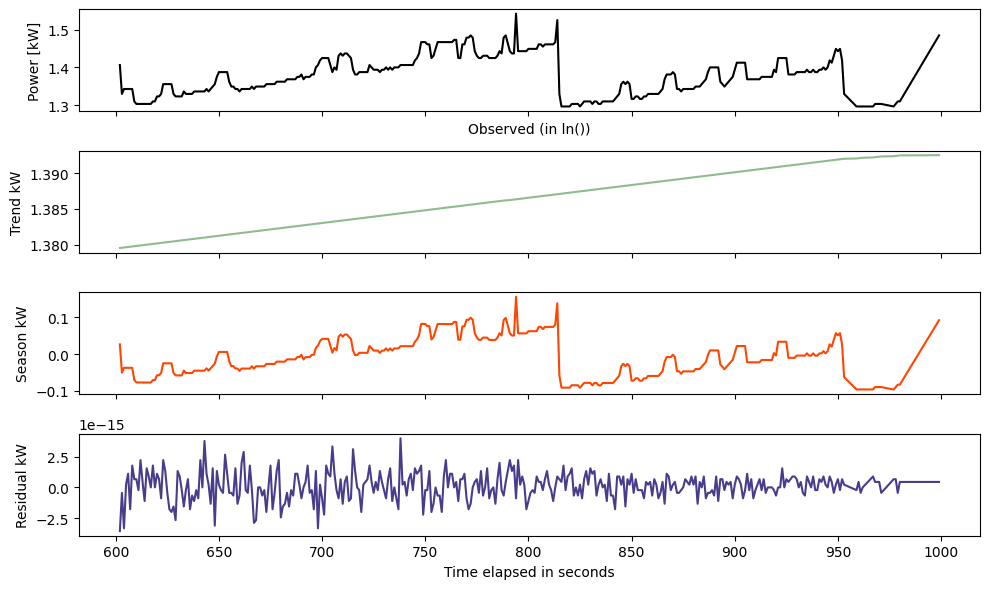

            Power
602 -3.552714e-15
603 -4.440892e-16
604 -3.330669e-15
605  2.220446e-16
606  1.110223e-15
..            ...
977  6.661338e-16
978  6.661338e-16
979 -4.440892e-16
980  4.440892e-16
999  4.440892e-16

[365 rows x 1 columns]


In [6]:
# first step stl
testData_01_power_df = testData_01_power_df.sort_index()
testData_01_power_df.reset_index(drop=True, inplace=True)
testData_01_power_df.dropna(subset=["Power"], inplace=True)
 #does that even make sense? It did although I assumed data was ordered in the csv file
# trend = math.ceil(1.5*60/(1- 1.5/301))
print(find_peaks(testData_01_power_df["Power"]))

stl_testData_power = STL.STL(testData_01_power_df["Power"], period=249, seasonal=31)
res = stl_testData_power.fit()

fig, axes = plt.subplots(4, 1, figsize=(10,6), sharex=True)
axes[0].plot(testData_01_power_df.index, res.observed, color="black")
axes[0].set_ylabel("Power [kW]")
axes[0].set_xlabel("Observed (in ln())")
print(res.observed)

axes[1].plot(testData_01_power_df.index, res.trend, color="darkseagreen")
axes[1].set_ylabel("Trend kW")

axes[2].plot(testData_01_power_df.index, res.seasonal, color="orangered")
axes[2].set_ylabel("Season kW")

axes[3].plot(testData_01_power_df.index, res.resid, color="darkslateblue")
axes[3].set_ylabel("Residual kW")
axes[3].set_xlabel("Time elapsed in seconds")

plt.tight_layout()
plt.show()

# Detrending as there not really seasons; remember that STL assumes seasonal>=7; reverse log operations for forecasting values
# Migh need to exp() later  pd.DataFrame(res.observed - res.resid)
detrended_data_df = pd.DataFrame(res.resid)
detrended_data_df.rename(columns={"resid" : "Power"}, inplace=True)
print(detrended_data_df)

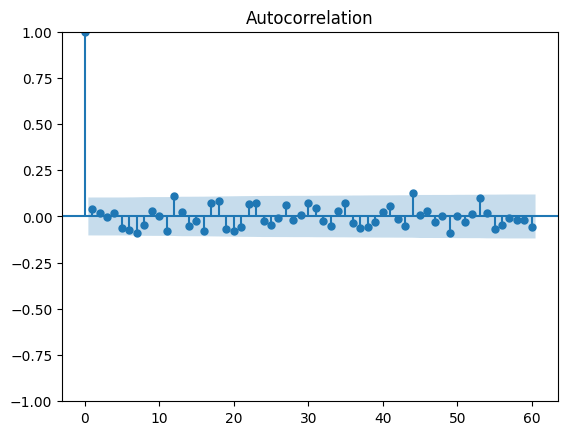

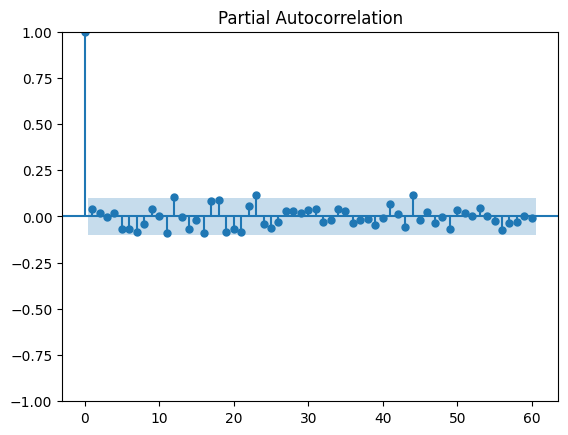

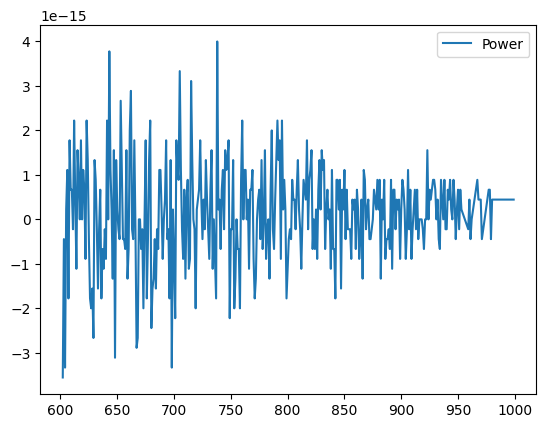

            Power
603  3.108624e-15
604 -2.886580e-15
605  3.552714e-15
606  8.881784e-16
607 -2.886580e-15
..            ...
977  1.110223e-15
978  0.000000e+00
979 -1.110223e-15
980  8.881784e-16
999  0.000000e+00

[364 rows x 1 columns]


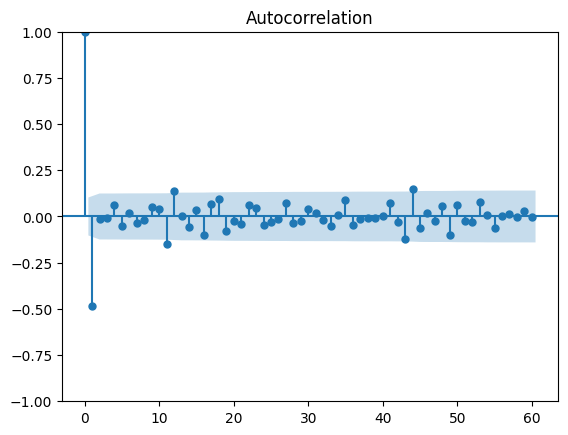

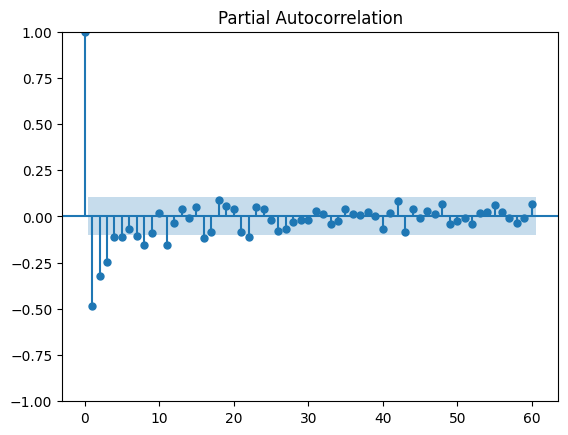

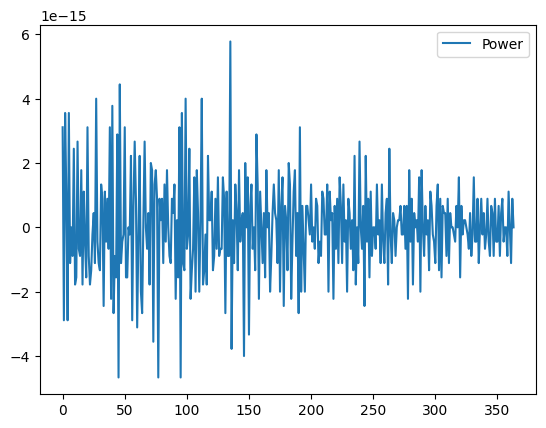

In [7]:
#stationary testing via ACF and PACF analysis
plot_acf(detrended_data_df["Power"], lags=60)
plt.show()
plot_pacf(detrended_data_df["Power"], lags=60)
plt.show()
detrended_data_df.plot()
plt.show()

# maybe higher order differencing as the PACF
differed_series = pd.DataFrame(detrended_data_df["Power"].diff().dropna())
print(differed_series)
plot_acf(differed_series["Power"], lags=60)
plt.show
plot_pacf(differed_series, lags=60)
plt.show()
differed_series.reset_index(drop=True, inplace=True)
differed_series.plot()
plt.show()

In [ ]:
# ARIMA
arima_Model = ARIMA(testData_01_power_df["Power"], order=(1,1,1))
arima_Result = arima_Model.fit()
print(arima_Result.summary())
forecast = arima_Result.forecast(steps=50)
print(np.exp(forecast))

c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scik

                               SARIMAX Results                                
Dep. Variable:                  Power   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3702.396
Date:                Tue, 28 Oct 2025   AIC                          -7398.791
Time:                        12:01:17   BIC                          -7387.100
Sample:                             0   HQIC                         -7394.144
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0618   8.12e-20    7.6e+17      0.000       0.062       0.062
ma.L1         -0.7718    8.5e-20  -9.08e+18      0.000      -0.772      -0.772
sigma2      1.305e-10   1.06e-10      1.236      0.2

c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
# implementation with a dropped time index
detrended_dropped_index = detrended_data_df.reset_index(drop=True).copy()
arima_Model = ARIMA(testData_01_power_df["Power"], order=(1,1,0))
arima_Result = arima_Model.fit()
print(arima_Result.summary())
forecast = arima_Result.forecast(steps=50)
print(np.exp(forecast))

                               SARIMAX Results                                
Dep. Variable:                  Power   No. Observations:                  365
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 902.070
Date:                Tue, 28 Oct 2025   AIC                          -1800.141
Time:                        12:04:13   BIC                          -1792.346
Sample:                             0   HQIC                         -1797.043
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0477      0.027     -1.786      0.074      -0.100       0.005
sigma2         0.0004   7.66e-06     53.789      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scik

In [10]:
#code graveyard: you never know

# Strom pipeline
# testData_01_power_df = testData_01[["Zeitstempel", "Strom"]].copy()
# # We will assume for now that NaN is equivalent to the machine just not running; optional: we could try to build a missing value handler 
# # based on linear interpolation (does that even make sense with electricity?) or maybe by estimating a value via loess regression
# # set up dataframe with timestamp as an index 
# testData_01_power_df.rename(columns= {"Zeitstempel": "Timestamp", "Strom": "Power"}, inplace = True)
# testData_01_power_df["Power"] = testData_01_power_df["Power"].str.replace(",", ".", regex=False) # german output contains "," which crashes stl afterwards
# testData_01_power_df["Power"] = pd.to_numeric(testData_01_power_df["Power"], errors = "raise") # if errors then its put into an NaN state
# testData_01_power_df.dropna(subset=["Power"], inplace = True)   #drop all rows containing NaN values in Power coloumn

# # setting up index and interpolate to get missing values 
# testData_01_power_df["Timestamp"] = pd.to_datetime(testData_01_power_df["Timestamp"])
# testData_01_power_df.set_index("Timestamp", inplace=True)
# print(testData_01_power_df)

# testData_01_power_df.index = (testData_01_power_df.index  - testData_01_power_df.index[0]).total_seconds()
# testData_01_power_df.drop(testData_01_power_df.index[-1], inplace=True) # dropped as that row was two days later or something
# display(testData_01_power_df)